In [18]:
import os
import pandas as pd
import numpy as np
import talib

In [19]:
df = pd.read_csv('xrp15.csv')

In [20]:
df=df[::-1]

In [21]:
df=df.reset_index(drop=True)
df.rename(columns={"final":"close","vol":"volume"}, inplace = True)
df

,date,open,high,low,close,volume
0,2018-02-01T00:00:00,1210,1230,1210,1225,878765
1,2018-02-01T00:15:00,1220,1225,1215,1220,337274
2,2018-02-01T00:30:00,1220,1225,1215,1215,108277
3,2018-02-01T00:45:00,1215,1220,1210,1215,295402
4,2018-02-01T01:00:00,1215,1215,1195,1195,741194
...,...,...,...,...,...,...
73650,2020-03-11T14:30:00,253,255,253,254,366890
73651,2020-03-11T14:45:00,253,254,253,254,358423
73652,2020-03-11T15:00:00,254,255,253,254,436329
73653,2020-03-11T15:15:00,254,255,254,255,338067


In [22]:
def Indicators(df): # date close open high low volume 컬럼순 
                    # 결측치 33줄 생김 0~32 까지
    df['sma5'] = talib.SMA(np.asarray(df['close']), 5)
    df['sma20'] = talib.SMA(np.asarray(df['close']), 20)
    #df['sma120'] = talib.SMA(np.asarray(df['close']), 120)
    df['ema12'] = talib.SMA(np.asarray(df['close']), 12)
    df['ema26'] = talib.SMA(np.asarray(df['close']), 26)
    upper, middle, lower = talib.BBANDS(np.asarray(df['close']), timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['dn'] = lower
    df['mavg'] = middle
    df['up'] = upper
    df['pctB'] = (df.close - df.dn)/(df.up - df.dn)
    rsi14 = talib.RSI(np.asarray(df['close']), 14)
    df['rsi14'] = rsi14
    macd, macdsignal, macdhist = talib.MACD(np.asarray(df['close']), 12, 26, 9)  
    df['macd'] = macd
    df['macdsignal'] = macdsignal
    df['obv']=talib.OBV(df['close'], df['volume'])
    df['ad'] = talib.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ADOSC'] = talib.ADOSC(df['high'], df['low'], df['close'], df['volume'], fastperiod=3, slowperiod=10)
    return df

In [23]:
df[['close','open','high','low','volume']]=df[['close','open','high','low','volume']].astype(float)
df=Indicators(df)

In [24]:
df.loc[32:33]

,date,open,high,low,close,volume,sma5,sma20,ema12,ema26,dn,mavg,up,pctB,rsi14,macd,macdsignal,obv,ad,ADOSC
32,2018-02-01T08:00:00,1235.0,1235.0,1225.0,1230.0,272240.0,1231.0,1224.75,1227.500000,1223.846154,1212.310145,1224.75,1237.189855,0.711015,53.368883,NaN,NaN,835557.0,847906.0,245393.091248
33,2018-02-01T08:15:00,1230.0,1250.0,1225.0,1240.0,531504.0,1233.0,1226.00,1228.333333,1224.807692,1212.733501,1226.00,1239.266499,1.027645,60.478616,4.697729,3.553998,1367061.0,954206.8,249554.419485


In [25]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,RobustScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

look_back = 50
def create_dataset(dataset, look_back=50):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)].values.tolist()
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back]['close'])
    return np.array(dataX), np.array(dataY)

df=df.iloc[33:]
df=df.fillna(0)
df=df.drop(columns=['date'])
nptf=np.array(df)

In [9]:

# normalization
Xscaler = RobustScaler()
Yscaler = RobustScaler()
Xscaler.fit(nptf)
Yscaler.fit(nptf[:,3].reshape(-1,1))

nptf = pd.DataFrame(Xscaler.transform(nptf),columns=df.columns)


In [10]:

# split train, test
train_size = int(len(nptf) * 0.95)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
 
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],  trainX.shape[1],19))
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],19))
 
# simple lstm network learning
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 19)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=40, batch_size=512, verbose=1)
 

69940 3682

Epoch 1/40
69889/69889 [==============================] - 10s 143us/step - loss: 0.0497
Epoch 2/40
69889/69889 [==============================] - 9s 130us/step - loss: 0.0012
Epoch 3/40
69889/69889 [==============================] - 9s 131us/step - loss: 8.2121e-04
Epoch 4/40
69889/69889 [==============================] - 9s 128us/step - loss: 6.8550e-04
Epoch 5/40
69889/69889 [==============================] - 9s 127us/step - loss: 5.6882e-04
Epoch 6/40
69889/69889 [==============================] - 9s 127us/step - loss: 5.2014e-04
Epoch 7/40
69889/69889 [==============================] - 9s 127us/step - loss: 5.0872e-04
Epoch 8/40
69889/69889 [==============================] - 9s 127us/step - loss: 4.9720e-04
Epoch 9/40
69889/69889 [==============================] - 10s 138us/step - loss: 4.7034e-04
Epoch 10/40
69889/69889 [==============================] - 9s 130us/step - loss: 4.9250e-04
Epoch 11/40
69889/69889 [==============================] - 9s 129us/step - loss: 4.

In [11]:

# make prediction
testPredict = model.predict(testX)
testPredict = Yscaler.inverse_transform(testPredict)
testY = Yscaler.inverse_transform(testY.reshape(-1,1))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 2.13 RMSE


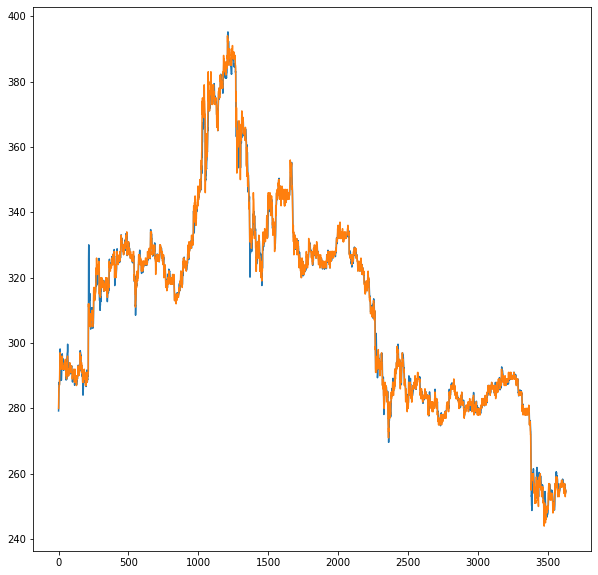

In [12]:

# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testPredict)
plt.plot(testY)
plt.show()

In [13]:
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = 'Xscale.pkl' 
joblib.dump(Xscaler, file_name) 
file_name = 'Yscale.pkl' 
joblib.dump(Yscaler, file_name)

/home/gim_su_hyun/anaconda3/envs/shs/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['Yscale.pkl']

In [14]:
from keras.models import load_model
model.save('LSTM.h5')

In [15]:
xs=joblib.load('Xscale.pkl')
ys=joblib.load('Yscale.pkl')
LSTM = load_model('LSTM.h5')

In [16]:
# make prediction
tp = LSTM.predict(testX)
tp = ys.inverse_transform(tp)

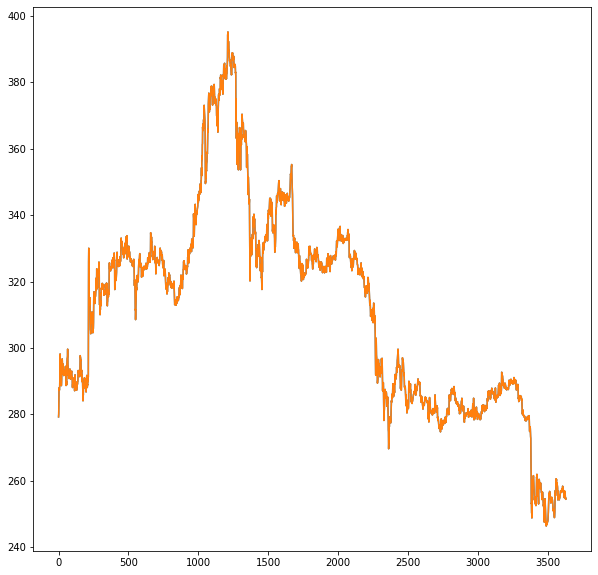

In [17]:

# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testPredict)
#plt.plot(testY)
plt.plot(tp)
plt.show()

In [26]:
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        a = dataset.iloc[i].values.tolist()
        dataX.append(a)
        dataY.append(dataset.iloc[i+1]['close'])
    return np.array(dataX), np.array(dataY)

In [27]:
nptf

array([[ 1.23000000e+03,  1.25000000e+03,  1.22500000e+03, ...,
         1.36706100e+06,  9.54206800e+05,  2.49554419e+05],
       [ 1.23500000e+03,  1.25000000e+03,  1.23500000e+03, ...,
         1.87852600e+06,  1.46567180e+06,  3.91308879e+05],
       [ 1.25000000e+03,  1.26500000e+03,  1.24500000e+03, ...,
         3.36305500e+06,  2.20793630e+06,  6.49900874e+05],
       ...,
       [ 2.54000000e+02,  2.55000000e+02,  2.53000000e+02, ...,
         6.99501062e+08, -2.97498322e+08, -2.73653320e+05],
       [ 2.54000000e+02,  2.55000000e+02,  2.54000000e+02, ...,
         6.99839129e+08, -2.97160255e+08, -1.13024168e+05],
       [ 2.55000000e+02,  2.55000000e+02,  2.54000000e+02, ...,
         6.99776276e+08, -2.97223108e+08, -5.70360000e+04]])

In [28]:

nptf = pd.DataFrame(nptf,columns=df.columns)

In [29]:

# split train, test
train_size = int(len(nptf) * 0.95)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# create dataset for learning
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

69940 3682


In [32]:
import lightgbm as lgb
train_ds = lgb.Dataset(trainX, label = trainY) 
test_ds = lgb.Dataset(testX, label = testY) 

In [42]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [53]:
params = {'learning_rate': 0.01,
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse'
          }

In [54]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3641.62
[200]	valid_0's l2: 489.363
[300]	valid_0's l2: 68.4301
[400]	valid_0's l2: 11.557
[500]	valid_0's l2: 3.91752
[600]	valid_0's l2: 2.88718
[700]	valid_0's l2: 2.72871
[800]	valid_0's l2: 2.69823
[900]	valid_0's l2: 2.68239
[1000]	valid_0's l2: 2.67575
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 2.67575


In [57]:
file_name = 'lgb2.pkl' 
joblib.dump(model, file_name) 

['lgb2.pkl']

In [55]:
predict_test = model.predict(testX)

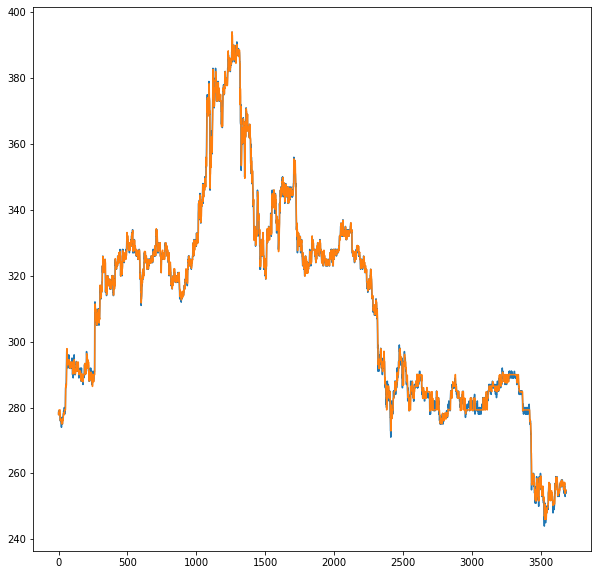

In [56]:
# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testY)
plt.plot(predict_test)
plt.show()

In [36]:
import xgboost
model = xgboost.XGBRegressor(learning_rate=0.1,
                             max_depth=5,
                             n_estimators=100) 
model.fit(trainX,trainY)

[23:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [37]:
file_name = 'xgb.pkl' 
joblib.dump(model, file_name) 

['xgb.pkl']

In [129]:
predict_test = model.predict(testX)

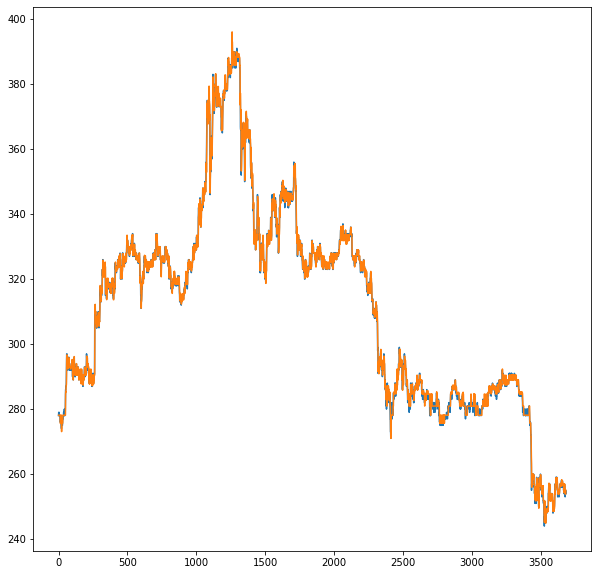

In [130]:
# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testY)
#plt.plot(testY)
plt.plot(predict_test)
plt.show()